In [305]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, FermiDirac
from gpaw import restart

# Size of the unit cell (Ångstrom)
a = 10.0

# Defining a single H atom at the corner of the cell.
atoms = Atoms('H', positions=[(0, 0, 0)], cell=(a, a, a))

# Defining a GPAW planewave calculator.
calc = GPAW(mode=PW(450),
            xc='PBE',
            occupations=FermiDirac(0.0, fixmagmom=True),
            txt=None
            )

# Setting the calculator for the atoms and getting the ground-state electron density.
atoms.calc = calc
atoms.get_potential_energy();

In [380]:
from gpaw.utilities.ps2ae import PS2AE
from ase.units import Bohr

# Function for converting the pseudo electron density into the all-electron density on a given fine grid.
h = 0.02
t = PS2AE(calc, grid_spacing=h)

# Smearing width for the nuclear potential.
smear = 0.01 * Bohr

# Function for getting the full electrostatic potential; zero level is normalized and the sign flipped.
ps2ae = t.get_electrostatic_potential(rcgauss=smear)
ps2ae -= ps2ae.max()
ps2ae = -ps2ae

# Choosing a radial line passing through the nucleus.
dftpot = ps2ae[0,0]

In [381]:
from abtem.parametrizations import kirkland, load_kirkland_parameters
from abtem.potentials import kappa

# Parameterized potential by Kirkland.
parameters = load_kirkland_parameters()

# Defining a position coordinate and computing the values of the potential (kappa is a conversion factor).
r = np.linspace(0, atoms.cell[-1], ps2ae.shape[-1])
iampot = kirkland(r[:], parameters[1]) / kappa

In [382]:
from numpy import pi, exp

q = 1.602176*10**-19;
eps0 = 8.854188*10**-12;

# Exact solution of the  electrostatic potential of hydrogen.
y = q/(4*pi*eps0)*exp(-2*r[1:][:,2]/a0)/(r[1:][:,2]*a0*10**-10) * (a0 + r[1:][:,2]/a0)

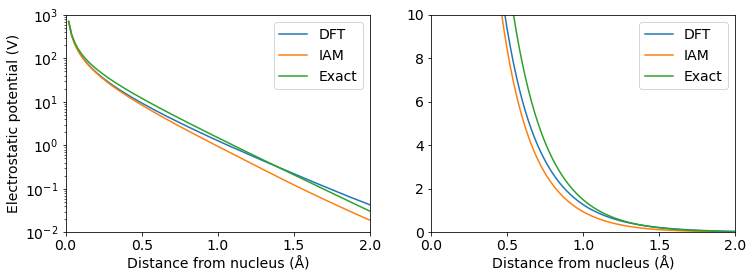

In [391]:
# Plotting the comparison between the three models.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.set_xlim((0.0,2.0));
ax1.set_ylim((0.01,1000));
ax1.plot(r[1:][:,2], dftpot[1:], label='DFT')
ax1.plot(r[1:][:,2], iampot[1:][:,2], label='IAM')
ax1.plot(r[1:][:,2], y, label='Exact');
ax1.legend();
ax1.set_yscale('log')
ax1.set_xlabel('Distance from nucleus (Å)')
ax1.set_ylabel('Electrostatic potential (V)')

ax2.set_xlim((0.0,2.0));
ax2.set_ylim((0.0,10.0));
ax2.plot(r[1:][:,2], dftpot[1:], label='DFT')
ax2.plot(r[1:][:,2], iampot[1:][:,2], label='IAM')
ax2.plot(r[1:][:,2], y, label='Exact');
ax2.legend();
ax2.set_xlabel('Distance from nucleus (Å)')
#ax2.set_ylabel('Electrostatic potential (V)')

plt.rcParams['font.size'] = 14